In [1]:
import serial
import struct
import time
import numpy as np
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from serial.tools.list_ports import comports

def read_number(msg):
    return int(input(msg))

def read_port(msg):
    port = input(msg)
    #index = input(msg)
    #port = "COM8";
    return serial.Serial(port, 9600)

            
def print_until_keyword(keyword, device):
    while True: 
        msg = device.serial.readline().decode()
        if msg[:-2] == keyword: break
        #else: print(f'({arduino.port}):',msg, end='')
            
def read_matrix(device, dimms):
    result = np.zeros((1,dimms)).reshape(-1)
    for i in range(dimms):
        device.serial.read()
        result[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return result.reshape(dimms)

clear = lambda: os.system('clear')

2023-11-12 15:19:56.462776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Device:
    def __init__(self, serial):
        self.serial = serial
        self.weights = []
        self.metalayers = []
        self.gradients = []
        
    def set_weights(self, weights):
        self.weights = weight
        
    def set_metadata(self, metalayer):
        self.metalayer = metalayer
        
def getDevices():
    num_devices = read_number("Number of devices: ")
    # num_devices = 2
    #num_devices=3

    available_ports = comports()
    print("Available ports:")
    for available_port in available_ports: print(available_port)

    time.sleep(1)
    devices = [read_port(f"Port device_{i+1}: ") for i in range(num_devices)]
    #devices= [serial.Serial(port, 9600) for port in ['/dev/cu.usbmodem14101', '/dev/cu.usbmodem14201','/dev/cu.usbmodem14301']]
    list_devices = []
    for device in devices:
        list_devices.append(Device(device))
    return list_devices

class Layer:
    def __init__(self, layer_type):
        self.layer_type = layer_type
        
    def __repr__(self):
        return f"{self.layer_type}"
    
class Dense(Layer):
    def __init__(self, rows, cols):
        super().__init__("Dense")
        self.rows = rows
        self.cols = cols
        
    def __repr__(self):
        return f"{self.layer_type=} {self.rows=} {self.cols=}"
    
class MaxPooling(Layer):
    def __init__(self, r, c, ch):
        super().__init__("MaxPooling")
        self.rows = r
        self.cols = c
        self.ch = ch
        
    def __repr__(self):
        return f"{self.layer_type}  - {self.rows=} {self.cols=} {self.ch=}"
    
class Conv2D(Layer):
    def __init__(self, kh, kw, c, kc):
        super().__init__("Conv2D")
        self.kh = kh
        self.kw = kw
        self.c = c
        self.kc = kc
        
    def __repr__(self):
        return f"{self.layer_type=} - {self.kh=} {self.kw=} {self.c=} {self.kc=}"
        

In [3]:
def receive_model_info(device):
    device.serial.reset_input_buffer()
    device.serial.write(b's')
    print_until_keyword('start', device) # CLEAN SERIAL
    
    bytesToRead = device.serial.read(1).decode()
    time.sleep(1)
    if bytesToRead == 'i':
        device.serial.write(struct.pack('f', LEARNING_RATE))
        [num_layers] = struct.unpack('i', device.serial.read(4))
        layers = []
        for i in range(num_layers):
            [layer_type] = struct.unpack('i', device.serial.read(4))
            if layer_type == -1:
                [rows, cols] = struct.unpack('ii', device.serial.read(8))
                layers.append(Dense(rows, cols))
            elif layer_type == -2:
                [rows, cols, ch] = struct.unpack('iii', device.serial.read(12))
                layers.append(MaxPooling(rows,cols,ch))
            elif layer_type == -3:
                [kh, kw, c, kc] = struct.unpack('iiii', device.serial.read(16))
                layers.append(Conv2D(kh,kw,c,kc))
            # dimms.append((1,cols)) # bias
            # dimms.append((rows,cols)) # matrix weigths
        device.metalayers = layers
    return num_layers, layers


In [4]:
import random    
## RECEIVE MODEL WEIGHT
def get_device_weights(device, bias_dimm, w_dimm):
    number_of_floats = w_dimm[0] * w_dimm[1]
    weights = np.zeros(w_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
        
    number_of_floats = bias_dimm[0] * bias_dimm[1]
    bias = np.zeros(bias_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape(w_dimm), bias.reshape(bias_dimm)
    
def get_device_weights_cnn(device, kh, kw, c, kc):
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.zeros((kh, kw, c, kc)).reshape(-1)
    for i,w in enumerate(weights.reshape(-1)):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
            
    bias = np.zeros((1,kc)).reshape(-1)
    for i,b in enumerate(bias.reshape(-1)):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape((kh, kw, c, kc)), bias.reshape((1,kc))

def get_device_weights_pool(device, rows, cols, ch):
    weights = np.random.randn(rows, cols, ch).reshape(-1)
    for i,w in enumerate(weights.reshape(-1)):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape((rows, cols, ch))
    

In [5]:
def initialize_device_weights(device, bias_dimm, w_dimm):
    np.random.seed(42)
    random.seed(42)
    bias = np.zeros(bias_dimm)
    weights = np.random.randn(w_dimm[0], w_dimm[1]) * np.sqrt(6.0 / (w_dimm[0] + w_dimm[1]))
    return weights, bias
    device.serial.write(struct.pack('f'*bias.reshape(-1).shape[0], *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f'*weights.reshape(-1).shape[0], *weights.reshape(-1)))
    
def initialize_device_weights_cnn(device, kh, kw, c, kc):
    np.random.seed(42)
    random.seed(42)
    bias = np.zeros((1,kc))
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.random.randn(kh, kw, c, kc) * np.sqrt(6.0 / (in_size + out_size))
    return weights, bias
    print(f"Sending weights for layer Conv2D")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
    device.serial.write(struct.pack('f'* bias.reshape(-1).shape[0], *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))

def create_initial_model(device, layers):
    weights = []
    for layer in layers:
        if layer.layer_type == "Conv2D":
            weights.append(initialize_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc))
        elif layer.layer_type == "Dense":
            weights.append(initialize_device_weights(device, (1,layer.cols), (layer.rows,layer.cols)))
        else:
            weights.append((np.array([]), np.array([])))
    return weights

    
def send_initial_weights(device, global_model):
    for weights, bias in global_model:
        #print(weights.shape, bias.shape)
        device.serial.write(struct.pack('f' * bias.reshape(-1).shape[0], *bias.reshape(-1)))
        device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))
    

In [6]:
def send_weights(device, weights, layer):
    bias = weights[1]
    weights = weights[0]
    #print(f"Sending bias for Dense {bias.reshape(-1).shape} {device.serial.port}")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
        #device.serial.write(struct.pack('f', b))
    if layer.layer_type != 'MaxPooling':
        device.serial.write(struct.pack('f' * bias.reshape(-1).shape[0],*bias.reshape(-1)))
        device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))

    #print(f"Sending weights for Dense {weights.reshape(-1).shape} {device.serial.port}")
    #for w in weights.reshape(-1):
        #data = device.serial.read()
        
def send_model_weights(device, weights):
    layers = device.metalayers
    device.serial.write(b'r')
 
    for i, layer in enumerate(weights):
        send_weights(device, weights[i], layers[i])

    #print(f"{device.serial.port} weights initialized!")

In [7]:
def get_model_weights(device):
    layers = device.metalayers
    device.serial.write(b'g') # Python --> ACK --> Arduino
    device.weights = []

    for i, layer in enumerate(layers):
        if layer.layer_type == "Conv2D":
            weights, biases = get_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
            device.weights.append((weights, biases))
        elif layer.layer_type == "Dense":
            weights, biases = get_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
            device.weights.append((weights, biases))
        elif layer.layer_type == "MaxPooling":
            #weights = get_device_weights_pool(device, layer.rows,layer.cols, layer.ch)
            device.weights.append((weights, np.array([])))
    #print(f"Model weight received!")

    
def get_model_gradients(device):
    layers = device.metalayers
    device.serial.write(b'g') # Python --> ACK --> Arduino
    device.gradients = []
    
    for i, layer in enumerate(layers):
        if layer.layer_type == "Conv2D":
            weights, biases = get_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
            device.gradients.append((weights, biases))
        elif layer.layer_type == "Dense":
            weights, biases = get_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
            device.gradients.append((weights, biases))
        elif layer.layer_type == "MaxPooling":
            #weights = get_device_weights_pool(device, layer.rows,layer.cols, layer.ch)
            device.gradients.append((np.array([]), np.array([])))
    #print(f"Model weight received!")


In [8]:
def send_sample(device, X, y=None):
    #if IS_KEYWORD_SPOTTING:
        #for i,k in enumerate(X.reshape(-1)):
            #device.serial.write(struct.pack('f',k))
            #print("SENT XX",i)
        #device.serial.write(struct.pack('h' * X.reshape(-1).shape[0], *X.reshape(-1)))
    #else:
    device.serial.write(struct.pack('f' * X.reshape(-1).shape[0], *X.reshape(-1)))

        #for i,k in enumerate(X.reshape(-1)):
            #raw = device.serial.read(4)
            #j = struct.unpack('i', raw)[0]
            #device.serial.write(struct.pack('f',k))
            #print("SENT",j, i)
            #print(f"returned error = {raw}")

    #print(f"Want to send y={y.shape}")
    if y is not None:
        device.serial.write(struct.pack('f' * y.reshape(-1).shape[0], *y.reshape(-1)))
        #for i, t in enumerate(y.reshape(-1)):
            #device.serial.read()
            #device.serial.write(struct.pack('f', t))
        #print(f"Sample y = {y.shape} sent!")

def get_tick():
    return time.time_ns()

def train_single(device, x, y, train_data):
    device.serial.write(b"t")
    send_sample(device, x, y.reshape(1,TARGET_SIZE))
    start = get_tick()
    output = read_matrix(device, TARGET_SIZE+1)
    end = get_tick()
    train_data['losses'][device.serial.port] = output[-1]
    train_data['times'][device.serial.port] = end-start
    res = output[:-1]
    train_data['acc'][device.serial.port] = 1 if np.argmax(y) == np.argmax(res) else 0


def train(device, X, y, size=1):
    error = 0.0
    for i in range(size):
        if i%100 == 0:
            print(f"{i}/{size} Done")
        device.serial.write(b"t")
        send_sample(device, X[i], y[i].reshape(1,TARGET_SIZE))
        #print("SAMPLE SENT")

        start = get_tick()
        output = read_matrix(device, TARGET_SIZE+1)
        #n_error = device.serial.read(4)
        #print(f"returned error = {n_error}")
        end = get_tick()
        loss = struct.unpack('f', n_error)[0]
        error += loss
    return end-start, error/size

def predict(device, X, y):
    device.serial.write(b"p")
    send_sample(device, X, y.reshape(1,TARGET_SIZE))
    # read last layer size output
    # Target size + 1 for the loss value
    start = get_tick()
    output = read_matrix(device, TARGET_SIZE+1)
    return get_tick() - start, output[:-1], output[-1]


- call getDevices() to obtain all conected devices
- asks the user how many devices you want to use
- send the initial model for every device
- create thread for every device
    - send samples and start training for one epoch
- wait for all threads to finish
- FEDERATED LEARNING
- create thread for every device and receive models
- permute the average of every layer
- create thread for every device and receive models
- send back the models

In [9]:
final_weights = []
def fl(devices):
    global final_weights
    
    # RECEIVE MODELS
    #print("Receiving models from devices...")
    threads = []
    for device in devices:
        thread = threading.Thread(target=get_model_weights, args=(device,))
        thread.daemon = True
        thread.start()
        threads.append(thread)

    for thread in threads: thread.join() # Wait for all the threads to end
    #print("Models received")
    # AVERAGE MODELS
    num_layers = len(devices[0].metalayers)
    assert num_layers > 0, "NO LAYERS!"

    #accuracies = fl_info_infer[-2]['accuracy']
    #total_accuracy = sum(accuracies.values())
    #normalized_accuracies = [accuracy / total_accuracy for accuracy in accuracies.values()]
    #print(normalized_accuracies)
    list_weights = []
    for i in range(num_layers):
        weights = np.array([device.weights[i][0] for device in devices])
        bias = np.array([device.weights[i][1] for device in devices])

        weights_avg = np.mean(weights, axis=0)
        bias_avg = np.mean(bias, axis=0)

        list_weights.append((weights_avg, bias_avg))
    #print("Average performed")
    # send model
    threads = []
    for device in devices:
        thread = threading.Thread(target=send_model_weights, args=(device, list_weights))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end
        
    final_weights = list_weights

In [10]:
def fl_sgd(devices):
    # RECEIVE MODELS
    threads = []
    for device in devices:
        thread = threading.Thread(target=get_model_gradients, args=(device,))
        thread.daemon = True
        thread.start()
        threads.append(thread)

    for thread in threads: thread.join() # Wait for all the threads to end
    #print("Models received")
    # AVERAGE MODELS
    num_layers = len(devices[0].metalayers)
    assert num_layers > 0, "NO LAYERS!"
    
    # GET GRADIENTS OF THE DEVICES
    list_weights = []
    for i in range(num_layers):
        gradients_w, gradients_b = devices[0].gradients[i]
        gradients_w = np.zeros_like(gradients_w)
        gradients_b = np.zeros_like(gradients_b)
        for k,device in enumerate(devices):
            #print(device.gradients[i][0])
            #print(device.gradients[i][1])
            gradients_w += device.gradients[i][0]
            gradients_b += device.gradients[i][1]
        
        list_weights.append((gradients_w,gradients_b))

    # SGD HERE
    for i, layer in enumerate(devices[0].metalayers):
        print("FF",list_weights[i][0], list_weights[i][1])
        if layer.layer_type == "MaxPooling":
            continue
        dw = iglobal_model[i][0] - list_weights[i][0] * 0.01
        db = iglobal_model[i][1] - list_weights[i][1] * 0.01
        
        iglobal_model[i] = (dw, db)
    
    
    # send model
    threads = []
    for device in devices:
        thread = threading.Thread(target=send_model_weights, args=(device, iglobal_model))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end



In [11]:
def train_device(device, X_train, Y_train,  info, steps = 1):
    device_losses = []
    device_times = []
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    
    if not isinstance(Y_train, np.ndarray):
        Y_train = np.array(Y_train)
    
    dt, loss = train(device, np.array(X_train).astype(np.int16), Y_train, steps)
    device_losses.append(loss)
    device_times.append(dt)
        
    info['losses'][device.serial.port] = device_losses
    info['train_time'][device.serial.port] = device_times

In [12]:
def predict_device(device, X, Y_test, info):
    device_times = []
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    acc = 0.0
    total_loss = 0.0
    df_time = 0
    for i, x in enumerate(X):
        if i%100 == 0:
            print(f"{device.serial.port} => [{i}/{X.shape[0]}] Done")
        
        dt, res, loss = predict(device, x, Y_test[i])
        acc += 1 if np.argmax(Y_test[i]) == np.argmax(res) else 0
        df_time += dt
        total_loss += loss
    info['accuracy'][device.serial.port] = acc/X.shape[0]
    info['infer_time'][device.serial.port] = df_time / X.shape[0]
    info['losses'][device.serial.port] = total_loss/X.shape[0]
    #info['res'][device.serial.port] = res


In [13]:
def get_fashion(num_clients=3, iid=True):
    # Load the Fashion MNIST dataset
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    Y_train = np_utils.to_categorical(y_train, 10)
    Y_test = np_utils.to_categorical(y_test, 10)

    if iid:
        # Shuffle the training data and labels
        random_indices = np.random.permutation(len(X_train))
        X_train = X_train[random_indices]
        Y_train = Y_train[random_indices]

        # Split the training data equally among the three clients
        split_size = len(X_train) // num_clients
        X_train_client1 = X_train[:split_size]
        X_train_client2 = X_train[split_size:2*split_size]
        X_train_client3 = X_train[2*split_size:]
        Y_train_client1 = Y_train[:split_size]
        Y_train_client2 = Y_train[split_size:2*split_size]
        Y_train_client3 = Y_train[2*split_size:]
        

        return np.concatenate((X_train_client1, X_train_client2, X_train_client3)), np.concatenate((Y_train_client1, Y_train_client2, Y_train_client3)), X_test, Y_test
    else:
        # Sort the training data by class labels
        sorted_indices = np.argsort(y_train)
        X_train = X_train[sorted_indices]
        Y_train = Y_train[sorted_indices]

        # Assign data to clients based on class labels
        # Calculate the split size
        split_size = len(X_train) // num_clients

        # Assign data to clients based on class labels
        X_train_client1 = X_train[:split_size]
        X_train_client2 = X_train[split_size:2*split_size]
        X_train_client3 = X_train[2*split_size:]
        Y_train_client1 = Y_train[:split_size]
        Y_train_client2 = Y_train[split_size:2*split_size]
        Y_train_client3 = Y_train[2*split_size:]


        return np.concatenate((X_train_client1, X_train_client2, X_train_client3)), np.concatenate((Y_train_client1, Y_train_client2, Y_train_client3)), X_test, Y_test


In [14]:
def reset_device(device):
    device.serial.write(b'f')

In [15]:
import threading
import time
devices = []
LEARNING_RATE = 0.001
TARGET_SIZE = 10
IS_KEYWORD_SPOTTING = False
def initialize_devices(lr = 0.001, target_size = 10, first=True):
    global devices
    global LEARNING_RATE
    global TARGET_SIZE
    
    TARGET_SIZE = target_size
    LEARNING_RATE = lr
    if first:
        devices = getDevices()
    else:
        threads = []
        for device in devices:
            print(f"RESETING DEVICE {device.serial.port}")
            thread = threading.Thread(target=reset_device, args=(device, ))
            thread.daemon = True
            threads.append(thread)

          # Start all the threads
        for thread in threads:
            thread.start()

        # Wait for all the threads to finish
        for thread in threads:
            thread.join()
        
    number_devices = 3
    
    time.sleep(3)
    
    threads = []
    for i, d in enumerate(devices):
        print(f"Receiving model info {i}")
        thread = threading.Thread(target=receive_model_info, args=(d, ))
        thread.daemon = True
        threads.append(thread)

      # Start all the threads
    for thread in threads:
        thread.start()

    # Wait for all the threads to finish
    for thread in threads:
        thread.join()

    iglobal_model = create_initial_model(devices[0], devices[0].metalayers)

    threads = []
    for i, d in enumerate(devices):
        print(f"Sending blank model for device {i}")
        thread = threading.Thread(target=send_initial_weights, args=(d, iglobal_model ))
        thread.daemon = True
        threads.append(thread)

      # Start all the threads
    for thread in threads:
        thread.start()

    # Wait for all the threads to finish
    for thread in threads:
        thread.join()
    print("All devices were initialized!")

In [16]:
def fashion_subset():
    from keras.datasets import fashion_mnist
    import numpy as np

    np.random.seed(42)  # Set seed for reproducibility

    # Load the Fashion-MNIST dataset
    (X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
    
    #xs = {key:0 for key in range(10)}
    #X = []
    #Y = []
    #for k in xs:
        #for i,y in enumerate(Y_train):
            #if y == k and xs[k] < 400:
                #X.append(X_train[i])
                #Y.append(Y_train[i])
                #xs[k] += 1
    #X_train, Y_train = np.array(X), np.array(Y)
    # Sort the training data by class labels
    sorted_indices = np.argsort(Y_train)
    X_train = X_train[sorted_indices]
    Y_train = Y_train[sorted_indices]

    # Assign data to clients based on class labels
    # Calculate the split size
    split_size = len(X_train) // 3

    # Assign data to clients based on class labels
    # Shuffle the data and labels independently for each client slice
    indices_client1 = np.random.permutation(split_size)
    indices_client2 = np.random.permutation(split_size)
    indices_client3 = np.random.permutation(split_size)

    X_train_client1 = X_train[:split_size][indices_client1]
    X_train_client2 = X_train[split_size:2 * split_size][indices_client2]
    X_train_client3 = X_train[2 * split_size:][indices_client3]

    Y_train_client1 = Y_train[:split_size][indices_client1]
    Y_train_client2 = Y_train[split_size:2 * split_size][indices_client2]
    Y_train_client3 = Y_train[2 * split_size:][indices_client3]


    return np.concatenate((X_train_client1, X_train_client2, X_train_client3)), np_utils.to_categorical(np.concatenate((Y_train_client1, Y_train_client2, Y_train_client3)),10), X_test, Y_test


In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot(all_losses_devices, samples=20000, step=1000):
    line_styles = ['-', '--', ':', '-.']
    markers = ['o', 's', 'D', '^']
    # Enable interactive mode
    plt.figure(figsize=(10,6))
    for i,device in enumerate(all_losses_devices):
        linestyle = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        plt.plot(all_losses_devices[device], label=f"Device {device}", linestyle=linestyle)

    plt.xticks(range(0,samples,step))
    plt.xlabel('Samples')
    plt.ylabel('Loss')
    plt.title('Training Losses. FL Round every 25 Samples.')
    plt.legend()
    plt.show()

In [21]:
def get_info(info, key_to_get='losses'):
    all_losses_devices = {}
    fl_devices = set()
    for fl_round in info:
        for key in fl_round:
            if key == key_to_get:
                losses = fl_round[key] 
                for device in losses:
                    if device in all_losses_devices:
                        all_losses_devices[device].append(losses[device])
                    else:
                        all_losses_devices[device] = []
                        all_losses_devices[device].append(losses[device])
    return all_losses_devices

In [22]:
import pickle 
def train_with_fl(num_devices=3, fl_samples=100, lr=0.001, first=True, iid=True, dataset=fashion_subset):
    initialize_devices(lr=lr, target_size=10, first=first)
    X_train, Y_train, X_test, Y_test  = dataset()#get_fashion(num_clients=3, iid=iid)
    total_size = X_train.shape[0]
    each_device_size = total_size // num_devices

    fl_rounds = 0
    X_Train = [X_train[0:each_device_size], X_train[each_device_size:each_device_size*2], X_train[each_device_size*2:each_device_size*3]]
    Y_Train = [Y_train[0:each_device_size], Y_train[each_device_size:each_device_size*2], Y_train[each_device_size*2:each_device_size*3]]

    #X_Train = [X_train[0:each_device_size], X_train[each_device_size:each_device_size*2], X_train[each_device_size*2:each_device_size*3]]
    #Y_Train = [X_train[0:each_device_size], X_train[each_device_size:each_device_size*2], X_train[each_device_size*2:each_device_size*3]]

    training_accuracies = {'/dev/cu.usbmodem14201':[], '/dev/cu.usbmodem14101':[], '/dev/cu.usbmodem14301':[]}

    training_data = []
    total_acc = {'/dev/cu.usbmodem14201':0, '/dev/cu.usbmodem14101':0, '/dev/cu.usbmodem14301':0}
    for i in range(each_device_size):
        if i%fl_samples==0 and i>0:
            fl(devices)
            fl_rounds += 1
        train_data = {'losses':{}, 'times':{}, 'acc':{}}
        threads = []
        for j, device in enumerate(devices):
            thread = threading.Thread(target=train_single, args=(device, X_Train[j][i],Y_Train[j][i], train_data))
            thread.daemon = True
            thread.start()
            threads.append(thread)
        for thread in threads: thread.join() # Wait for all the threads to end
        training_data.append(train_data)
        
        for d in train_data['acc']:
            total_acc[d] += train_data['acc'][d]
            training_accuracies[d].append(total_acc[d]/(i+1))

        print(f"{i}/{each_device_size} Done [{fl_rounds} FL rounds] Acc: \
          {total_acc['/dev/cu.usbmodem14101'] / (i+1):.3f}, {total_acc['/dev/cu.usbmodem14201'] / (i+1):.3f}, \
          {total_acc['/dev/cu.usbmodem14301'] / (i+1):.3f}         ----------", end='\r')


    # SET THE DEVICES WEIGHT AS THE GLOBAL MODEL
    fl(devices)
    print("\nFINISHED") 
    
    with open(f'losses/losses_4_{fl_samples}_{lr}_{iid}.pkl', 'wb') as f:
        pickle.dump(training_data, f)
        
    
    with open(f'weights/weights_4_{fl_samples}_{lr}_{iid}.pkl', 'wb') as f:
        pickle.dump(final_weights, f)

In [18]:
lrs = [0.01]
fl_rounds = [25]
first = True
for lr in lrs:
    for fl_round in fl_rounds:
        print(f"Doing {lr=} and {fl_round=}")
        train_with_fl(num_devices=3, fl_samples=fl_round, lr=lr, first=first, iid=False)
        first = False

Doing lr=0.01 and fl_round=25
Number of devices: 0
Available ports:
/dev/cu.wlan-debug - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbmodem14101 - Envie M7


KeyboardInterrupt: 

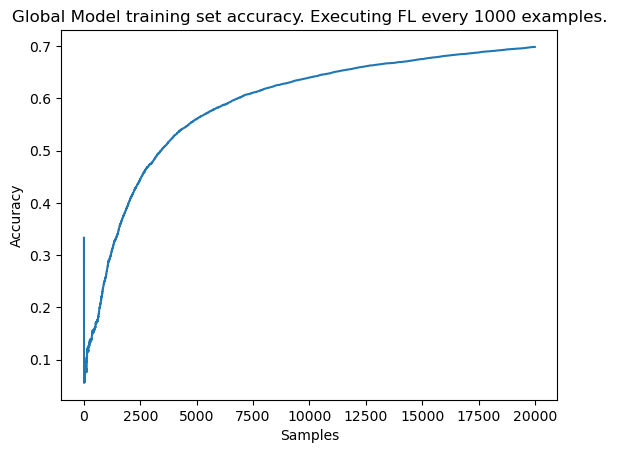

In [32]:
accs = []
total_acc = 0 
for i,sample_data in enumerate(loaded_dict):
    total_acc += sum([sample_data['acc'][dev] for dev in sample_data['acc']])
    accs.append(total_acc / ((i+1 )*3))
import matplotlib.pyplot as plt
plt.title('Global Model training set accuracy. Executing FL every 1000 examples.')
plt.plot(accs)
plt.xlabel('Samples')
plt.ylabel('Accuracy')
plt.show()

In [160]:
num_devices = 3
fl_every_epoch = 4 # number of epochs to execute fl
epochs = 1 # number of epochs to execute before every fl
fl_info_train = []
fl_info_infer = []
# uncomment this line to use the entire dataset
# steps = X_train.shape[0]
# 227451
#train_steps = X_train.shape[0]
#test_steps = X_test.shape[0]
# samples_each_device
#sdev = train_steps // num_devices
#tsdev = test_steps // num_devices
#print(f"Each device will receive {sdev} elements")

X_train, Y_train, X_test, Y_test = get_fashion(iid=True)

for epoch in range(epochs):
    info_infer = {'accuracy':{}, 'infer_time':{}, 'losses':{}, 'res':{}}
    threads = []
    #for device in devices:
    predict_device(devices[1], X_test, Y_test, info_infer)
    #for thread in threads: thread.join() # Wait for all the threads to end
    fl_info_infer.append(info_infer)
    #print(fl_info_infer)
    #info = {'losses':{}, 'train_time':{}}
    #threads = []
    #for i,device in enumerate(devices):
     #   thread = threading.Thread(target=train_device, args=(device, X_train[i*sdev:(i+1)*sdev], Y_train[i*sdev:(i+1)*sdev], info, sdev))
     #   thread.daemon = True
     #   thread.start()
     #   threads.append(thread)
    #for thread in threads: thread.join() # Wait for all the threads to end
    #print(f"Epochs => {epoch+1}/{epochs} done")
    #fl_info_train.append(info)
    
        #do federated learning
    #if epoch%fl_every_epoch==0 and epoch > 0:
     #   fl(devices)
     #   print("FedSGD Done.")
        
    #global_loss = 0.0
    #for d in fl_info_train[-1]['losses']:
    #    global_loss += fl_info_train[-1]['losses'][d][0]
    #print(global_loss/3)

print("FINISHED")

/dev/cu.usbmodem13101 => [0/10000] Done
/dev/cu.usbmodem13101 => [100/10000] Done
/dev/cu.usbmodem13101 => [200/10000] Done
/dev/cu.usbmodem13101 => [300/10000] Done
/dev/cu.usbmodem13101 => [400/10000] Done
/dev/cu.usbmodem13101 => [500/10000] Done
/dev/cu.usbmodem13101 => [600/10000] Done
/dev/cu.usbmodem13101 => [700/10000] Done
/dev/cu.usbmodem13101 => [800/10000] Done
/dev/cu.usbmodem13101 => [900/10000] Done
/dev/cu.usbmodem13101 => [1000/10000] Done
/dev/cu.usbmodem13101 => [1100/10000] Done
/dev/cu.usbmodem13101 => [1200/10000] Done
/dev/cu.usbmodem13101 => [1300/10000] Done
/dev/cu.usbmodem13101 => [1400/10000] Done
/dev/cu.usbmodem13101 => [1500/10000] Done
/dev/cu.usbmodem13101 => [1600/10000] Done
/dev/cu.usbmodem13101 => [1700/10000] Done
/dev/cu.usbmodem13101 => [1800/10000] Done
/dev/cu.usbmodem13101 => [1900/10000] Done
/dev/cu.usbmodem13101 => [2000/10000] Done
/dev/cu.usbmodem13101 => [2100/10000] Done
/dev/cu.usbmodem13101 => [2200/10000] Done
/dev/cu.usbmodem13101 =